In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.device('cuda')

device(type='cuda')

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [7]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

12297


In [9]:
# hpreact.std(0, keepdim=True)

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


/home/evan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      0/ 200000: 3.3135
  10000/ 200000: 2.4303
  20000/ 200000: 2.3075
  30000/ 200000: 2.4518
  40000/ 200000: 2.2219
  50000/ 200000: 2.0082
  60000/ 200000: 2.1928
  70000/ 200000: 2.3411
  80000/ 200000: 2.2607
  90000/ 200000: 1.6670
 100000/ 200000: 2.4687
 110000/ 200000: 1.9711
 120000/ 200000: 2.3987
 130000/ 200000: 1.9077
 140000/ 200000: 2.0456
 150000/ 200000: 2.2224
 160000/ 200000: 1.6696
 170000/ 200000: 1.6809
 180000/ 200000: 1.9745
 190000/ 200000: 1.6515


torch.Size([32, 200])

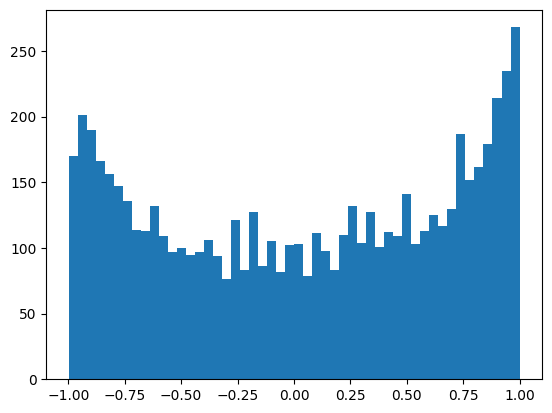

In [ ]:
plt.hist(h.view(-1).tolist(), 50)
h.shape

In [ ]:
logits[0]

tensor([-0.0218,  0.0798,  0.0787, -0.0195,  0.2671,  0.0886, -0.1677,  0.2509,
        -0.0037,  0.1718,  0.1116,  0.1306, -0.1733, -0.1678,  0.0765,  0.2876,
        -0.0743, -0.0841, -0.0622, -0.0464,  0.0668,  0.2036, -0.1610, -0.1523,
         0.0811,  0.1516,  0.0730], grad_fn=<SelectBackward0>)

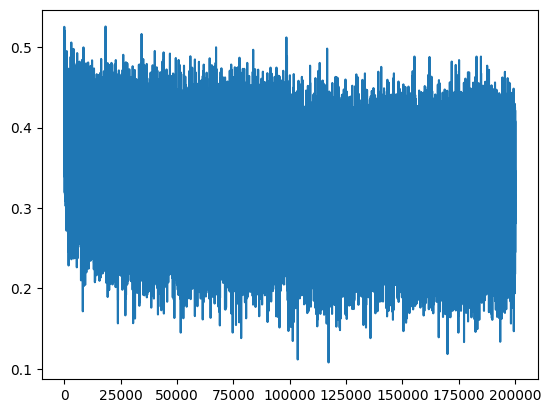

In [11]:
plt.plot(lossi)

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [12]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [13]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = 
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070533275604248
val 2.1087112426757812


In [ ]:
for _ in range(1):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # print(logits)
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        print(probs, ix)
        print(ix, probs[:, ix].item())
        
        prob_sum = 0
        for j in range(27):
            # print(j, itos[j], probs[:, j].item())
            prob_sum += probs[:, j].item()
        
        print(prob_sum)
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

tensor([[8.7747e-04, 5.3715e-15, 7.1058e-12, 1.5009e-05, 1.8605e-15, 1.3496e-19,
         9.2666e-20, 2.0206e-10, 9.9911e-01, 4.3523e-18, 1.2792e-12, 5.9226e-12,
         2.4580e-10, 1.2090e-17, 3.2924e-08, 5.5559e-13, 4.9027e-19, 3.6065e-09,
         5.2399e-08, 3.5329e-18, 1.0364e-17, 1.5405e-11, 2.0431e-10, 3.0225e-15,
         2.4977e-10, 5.7848e-12, 1.7574e-13]], grad_fn=<SoftmaxBackward0>) 8
8 0.9991074204444885
0.9999999859483661
tensor([[2.1915e-10, 1.9646e-08, 1.6557e-08, 9.8405e-01, 1.7865e-09, 2.4048e-16,
         8.5494e-04, 1.4600e-05, 1.9680e-08, 1.9304e-12, 1.7468e-09, 3.8369e-11,
         1.3836e-02, 1.0241e-09, 1.0428e-05, 8.5221e-06, 2.4571e-10, 1.2962e-13,
         1.3904e-08, 2.6029e-04, 6.9515e-09, 2.6035e-07, 9.0641e-04, 5.9789e-05,
         1.2189e-12, 1.7250e-08, 2.1438e-16]], grad_fn=<SoftmaxBackward0>) 3
3 0.9840489625930786
0.9999998952713914
tensor([[1.2472e-01, 1.0738e-10, 7.5413e-06, 4.1366e-01, 1.8965e-09, 2.5293e-01,
         7.7492e-10, 1.5757e-03, 2.13